<a href="https://colab.research.google.com/github/jrhumberto/cd/blob/main/3_4_Terceira_Estrategia_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.4 - Terceira estratégia

- Aplicado filtro bilateral

# Importando bibliotecas 

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import sys
import matplotlib.cbook
import numpy as np
import pandas as pd
import os 
import glob
import pathlib
import seaborn as sns
import IPython.display as display
import random
import math, re, time

# Import para manipulação das imagens
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
%matplotlib inline  
from skimage.transform import resize
from PIL import Image
import cv2

# Imports de bibliotecas para treinamento de redes neurais
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam, Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

import keras
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.7.0


# Versões utilizadas neste projeto:

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Projeto Visão Computacional" --iversions

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
Author: Projeto Visão Computacional

matplotlib: 3.2.2
keras     : 2.7.0
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
seaborn   : 0.11.2
PIL       : 7.1.2
re        : 2.2.1
pathlib   : 1.0.1
cv2       : 4.1.2
IPython   : 5.5.0
tensorflow: 2.7.0
numpy     : 1.19.5
pandas    : 1.1.5



# Carregamento e análise do dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Qual a quantidade total de imagens?

In [ ]:
data_dir = pathlib.Path('/content/drive/My Drive/data_especular_crop_4/')

In [ ]:

# Verificando quantas imagens tem nos diretórios
image_count = len(list(data_dir.glob('*/*.png')))
print('Quantidade total de Imagens: ', image_count)

Quantidade total de Imagens:  1387


## Quais as classes (rótulos) presentes?

In [ ]:
#Verificando todas as classes de flores (licenciadas)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
# Print das categorias de flores
print('Classes/rótulos: ', CLASS_NAMES)

Classes/rótulos:  ['integra' 'rara' 'confluente_esparsa']


## Qual o tamanho de cada uma destas classes?

In [ ]:
# Visualizando o tamanho de cada classe
fnames = []
for classes in CLASS_NAMES:
    images_folder = os.path.join(data_dir, classes)
    file_names    = os.listdir(images_folder)
    full_path     = [os.path.join(images_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

    tamanho_classes = [len(f) for f in fnames]
print('Tamanho de cada classe:', tamanho_classes)   

Tamanho de cada classe: [574, 574, 239]


## Qual o tamanho percentual de cada uma destas classes?

In [ ]:
tamanho_classes_percentual = [(X /image_count)*100 for X  in tamanho_classes]
print('Tamanho percentual de cada classe:', tamanho_classes_percentual)   

Tamanho percentual de cada classe: [41.38428262436914, 41.38428262436914, 17.231434751261716]


# Visualizando o dataset

### Diretórios das classes

In [ ]:
confluente_esparsa = list(data_dir.glob('confluente_esparsa/*'))
integra = list(data_dir.glob('integra/*'))
rara = list(data_dir.glob('rara/*'))

# Observações do dataset

- Existem 1386 imagens divididas em 3 classes, sendo elas: confluente_esparsa; integra; e rara.
- Sendo cerca de 41% das imagens são da classe "integra" e outros 41% da classe "rara"e 17% são confluente_esparsa. 

# Preparação dos Dados

- Redimensionar todas as imagens para um size específico (no caso 256 x 256)
- Separar 70% de amostras para treinamento, 20% para validação e 10% para testes
- Converter em formato numpy Keras

In [ ]:
# Carregando as imagens das fotos usando CV2
images = []
for names in fnames:
    one_class_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_class_images)

In [ ]:
# Verificando qual o melhor shape para o redimensionamento de todas as fotos
for i,imgs in enumerate(images):
    shapes  = [img.shape for img in imgs]
    widths  = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d é o menor shape para %s' % (np.min(widths), np.min(heights), CLASS_NAMES[i]))

455,245 é o menor shape para integra
455,245 é o menor shape para rara
455,245 é o menor shape para confluente_esparsa


In [ ]:
# Função para converter as imagens para formato RGB
def convert_to_RGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

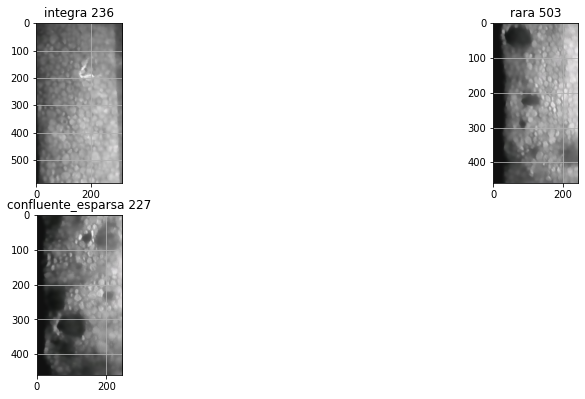

In [ ]:
# Exibindo alguns exemplos das imagens convertidas para RGB
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(3,2,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(convert_to_RGB(imgs[idx]))
    plt.grid('off')
    plt.title(CLASS_NAMES[i]+' '+str(idx))
plt.show()

In [ ]:
# Redimensionar todas as imagens para 256 x 256

# Definindo o tamanho do shape
img_width, img_height = 256, 256


In [ ]:
# Redimensionando TODAS as imagens com o openCV
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height),
                                      interpolation = cv2.INTER_CUBIC) for img in imgs])

In [ ]:
## Realizando o split dos dados para treinamento, validação e testes ~ (70/20/10)

# Criando as listas vazias
train_images = []
val_images   = []
test_images =  []
aux_images = []

# Loop percorrendo todaas as imagens redimensionadas e preenchendo as listas de treino e validação
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.9, test_size=0.1,
                                   random_state=42)
    aux_images.append(train)
    test_images.append(test)
    
for imgs2 in aux_images:
    train, val = train_test_split(imgs2, train_size=0.78, test_size=0.22, 
                                  random_state=42)
    train_images.append(train)
    val_images.append(val)

In [ ]:
## Criando os labels para as imagens de treinamento

# Exibindo a quantidade de dados para treinamento e a distribuição de cada classe
len_train_images = [len(imgs) for imgs in train_images]
print('Total para cada classe: ', len_train_images)
print('Total de imagens para treinamento:', np.sum(len_train_images))  

# Criando os labels de treinamento
train_classe = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(4):
    if i is 0:
        train_classe[:len_train_images[i]] = i
    else:
        train_classe[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

Total para cada classe:  [402, 402, 167]
Total de imagens para treinamento: 971


In [ ]:
## Criando os labels para as imagens de validação

# Exibindo a quantidade de dados para validação e a distribuição de cada classe
len_val_images = [len(imgs) for imgs in val_images]
print('Total para cada classe: ', len_val_images)
print('Total de imagens para validação:', np.sum(len_val_images))  

# Criando os labels de validação
val_classe = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(4):
    if i is 0:
        val_classe[:len_val_images[i]] = i
    else:
        val_classe[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

Total para cada classe:  [114, 114, 48]
Total de imagens para validação: 276


In [ ]:
## Criando os labels para as imagens de testes

# Exibindo a quantidade de dados para validação e a distribuição de cada classe
len_test_images = [len(imgs) for imgs in test_images]
print('Total para cada classe: ', len_test_images)
print('Total de imagens para testes:', np.sum(len_test_images))  

# Criando os labels de testes
test_classe = np.zeros((np.sum(len_test_images)), dtype='uint8')
for i in range(4):
    if i is 0:
        test_classe[:len_test_images[i]] = i
    else:
        test_classe[np.sum(len_test_images[:i]):np.sum(len_test_images[:i+1])] = i

Total para cada classe:  [58, 58, 24]
Total de imagens para testes: 140


In [ ]:
## Convertendo as imagens em formato array do numpy para submeter ao treinamento

# Criando listas temporarias
tmp_train_imgs = []
tmp_val_imgs   = []
tmp_test_imgs  = []

# Percorrendo o dataset de treinamento e adicionando na lista temporaria
for imgs in train_images:
    tmp_train_imgs += imgs

# Percorrendo o dataset de validação e adicionando na lista temporaria
for imgs in val_images:
    tmp_val_imgs += imgs

# Percorrendo o dataset de testes e adicionando na lista temporaria
for imgs in test_images:
    tmp_test_imgs += imgs

# Convertendo em formato array
train_images_np = np.array(tmp_train_imgs)
val_images_np   = np.array(tmp_val_imgs)
test_images_np   = np.array(tmp_test_imgs)

# Removendo listas temporarias
del tmp_train_imgs, tmp_val_imgs, tmp_test_imgs

In [ ]:
print('*** Antes de converter***')
print('train data:', train_images_np.shape)
print('train labels:', train_classe.shape)

# Transformando os dados para o tipo float32
train_data   = train_images_np.astype('float32')
val_data     = val_images_np.astype('float32')
test_data    = test_images_np.astype('float32')

# Converter o array de labels para cada classe em vetores one-hot 
train_labels = np_utils.to_categorical(train_classe, len(CLASS_NAMES))
val_labels   = np_utils.to_categorical(val_classe, len(CLASS_NAMES))
test_labels  = np_utils.to_categorical(test_classe, len(CLASS_NAMES))

print('\n*** Depois de converter ***')
print('Dados de treinamento:', train_data.shape)
print('Rotulos de treinamento:', train_labels.shape)

print('\n*** Depois de converter ***')
print('Dados de validação:', val_data.shape)
print('Rotulos de validação:', val_labels.shape)

print('\n*** Depois de converter ***')
print('Dados de testes:', test_data.shape)
print('Rotulos de testes:', test_labels.shape)

*** Antes de converter***
train data: (971, 256, 256, 3)
train labels: (971,)

*** Depois de converter ***
Dados de treinamento: (971, 256, 256, 3)
Rotulos de treinamento: (971, 3)

*** Depois de converter ***
Dados de validação: (276, 256, 256, 3)
Rotulos de validação: (276, 3)

*** Depois de converter ***
Dados de testes: (140, 256, 256, 3)
Rotulos de testes: (140, 3)


# Metricas

In [ ]:
metrics=[]
metrics.append(keras.metrics.Precision(name="precision"))
metrics.append(keras.metrics.Recall(name="recall"))

# Modelos

In [ ]:
# Definindo os parametros gerais para treinamento
batch_size = 16
epochs     = 25

In [ ]:
# Função para criar a estrutura de nosso modelo CNN
def create_model_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(CLASS_NAMES)))
    model.add(Activation('softmax'))
  
    input_shape=train_data.shape[1:]
    model.build((None,) + input_shape)


    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', 
        metrics= metrics)
    
    return model

In [ ]:
# Criando o modelo e verificando a estrutura
model_cnn = create_model_cnn()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                    

In [ ]:
# Função para criar a estrutura de nosso modelo usando como base o modelo pre-treinado VGG19
def create_model_vgg19():
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

    # Congelando as camadas que não seram treinadas (no caso as 5 primeiras)
    for layer in model.layers[:20]:
        layer.trainable = False

    # Adicionando nova camadas ao nosso modelo
    x = model.output
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(len(CLASS_NAMES), activation="softmax")(x)

    # Criando o modelo final
    final_model = Model(inputs = model.input, outputs = predictions)
    final_model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics= metrics)

    return final_model

In [ ]:
model_vgg19 = create_model_vgg19()
model_vgg19.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

# Treinamento dos Modelos

## Aplicando estratégias
- Neste primeiro cenário só usaremos rescale 

In [ ]:
# Aplicando data augmentation para melhorar a performance do modelo
# Para dataset de treinamento
train_datagen = ImageDataGenerator(rescale = 1./255,)
train_datagen.fit(train_data)

# Para dataset de validação
val_datagen = ImageDataGenerator(rescale=1./255)
val_datagen.fit(val_data)

In [ ]:
# Função para exibir o desempenho do modelo em treino e teste
def plot_model(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['precision'])), history['precision'], 'r')
  plt.plot(np.arange(1, len(history['val_precision'])+1), history['val_precision'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Precision vs. Validation Precision')
  plt.xlabel('Nro de Epochs')
  plt.ylabel('Precision')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['recall'])+1), history['recall'], 'r')
  plt.plot(np.arange(1, len(history['val_recall'])+1), history['val_recall'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Recall vs. Validation Recall')
  plt.xlabel('Nro de Epochs')
  plt.ylabel('Recall')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

## Modelo CNN

In [ ]:
# Marcando o tempo de início
start = time.time()

# Treinamento do modelo
# Realizando o treinamento do modelo CNN
history_cnn = model_cnn.fit(train_data, train_labels, batch_size = batch_size,
                            epochs = epochs, initial_epoch = 0, 
                            validation_data = (val_data, val_labels))
# Marcando o tempo final
end = time.time()
duration = end - start
print ('\n Modelo CNN - Duração %0.2f segundos (%0.1f minutos) para treinamento de %d epocas'%(duration, duration/60, epochs) )

Epoch 1/25
61/61 [==============================] - 22s 184ms/step - loss: 59.0195 - precision: 0.4104 - recall: 0.1133 - val_loss: 1.0665 - val_precision: 0.4286 - val_recall: 0.0109
Epoch 2/25
61/61 [==============================] - 9s 147ms/step - loss: 1.0485 - precision: 0.5303 - recall: 0.0360 - val_loss: 1.0478 - val_precision: 0.4286 - val_recall: 0.0109
Epoch 3/25
61/61 [==============================] - 9s 148ms/step - loss: 1.0163 - precision: 0.5586 - recall: 0.0639 - val_loss: 1.0203 - val_precision: 0.5000 - val_recall: 0.0254
Epoch 4/25
61/61 [==============================] - 9s 147ms/step - loss: 0.8365 - precision: 0.6430 - recall: 0.3728 - val_loss: 0.8241 - val_precision: 0.7344 - val_recall: 0.1703
Epoch 5/25
61/61 [==============================] - 9s 148ms/step - loss: 0.7085 - precision: 0.6866 - recall: 0.6138 - val_loss: 0.7672 - val_precision: 0.7719 - val_recall: 0.4783
Epoch 6/25
61/61 [==============================] - 9s 148ms/step - loss: 0.6549 - preci

Modelo CNN


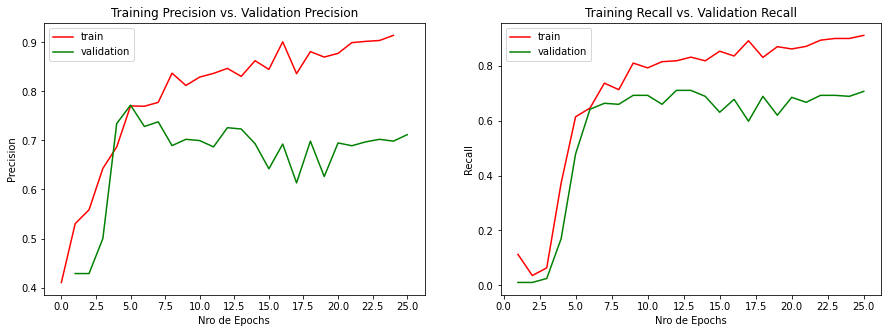

In [ ]:
# Exibindo o desempenho do modelo no Treinamento
plot_model('Modelo CNN', history_cnn.history, epochs)

## Modelo VGG19

In [ ]:
# Marcando o tempo de início
start = time.time()

# Realizando o treinamento do modelo VGG19
history_vgg19 = model_vgg19.fit(train_data, train_labels, batch_size = batch_size,
                                epochs = epochs, initial_epoch = 0, 
                                validation_data = (val_data, val_labels))

# Marcando o tempo final
end = time.time()
duration = end - start
print ('\n Modelo VGG19 - Duração %0.2f seconds (%0.1f minutos) para treinamento de %d epocas'%(duration, duration/60, epochs) )

Epoch 1/25
61/61 [==============================] - 30s 373ms/step - loss: 2.4197 - precision: 0.6227 - recall: 0.6022 - val_loss: 0.6105 - val_precision: 0.7442 - val_recall: 0.6957
Epoch 2/25
61/61 [==============================] - 15s 250ms/step - loss: 0.7337 - precision: 0.7317 - recall: 0.6993 - val_loss: 1.0133 - val_precision: 0.7200 - val_recall: 0.7174
Epoch 3/25
61/61 [==============================] - 15s 250ms/step - loss: 0.7340 - precision: 0.7476 - recall: 0.7106 - val_loss: 0.6524 - val_precision: 0.8074 - val_recall: 0.7899
Epoch 4/25
61/61 [==============================] - 15s 250ms/step - loss: 0.6257 - precision: 0.7683 - recall: 0.7446 - val_loss: 0.5659 - val_precision: 0.8333 - val_recall: 0.8152
Epoch 5/25
61/61 [==============================] - 15s 250ms/step - loss: 0.5349 - precision: 0.8061 - recall: 0.7920 - val_loss: 0.7351 - val_precision: 0.8182 - val_recall: 0.8152
Epoch 6/25
61/61 [==============================] - 15s 249ms/step - loss: 0.6184 - p

Modelo VGG19


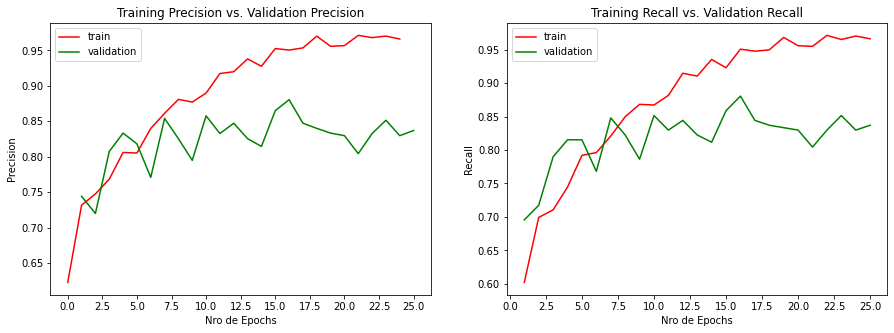

In [ ]:
# Exibindo o desempenho do modelo no Treinamento
plot_model('Modelo VGG19', history_vgg19.history, epochs)

# Avaliando Precisão e Recall na INFERENCIA

https://www.ti-enxame.com/pt/python/quais-valores-sao-retornados-de-model.evaluate-no-keras/805995760/

In [ ]:
# Função para realizar previsão da classe das imagens passadas como parâmetro
def predict_val(test_data, model):
  val_input = np.reshape(test_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)    

# Função para buscar a descrição do label
def desc_label(label):
  idx = np.where(label == 1)
  return idx[0][0]  

### CNN

In [ ]:
#test_precision, test_recall = model_cnn.evaluate(test_data, test_labels)
avaliacao = model_cnn.evaluate(test_data, test_labels, verbose=2)

5/5 - 3s - loss: 1.3735 - precision: 0.7279 - recall: 0.7071 - 3s/epoch - 527ms/step


***** Modelo CNN Treinado *****



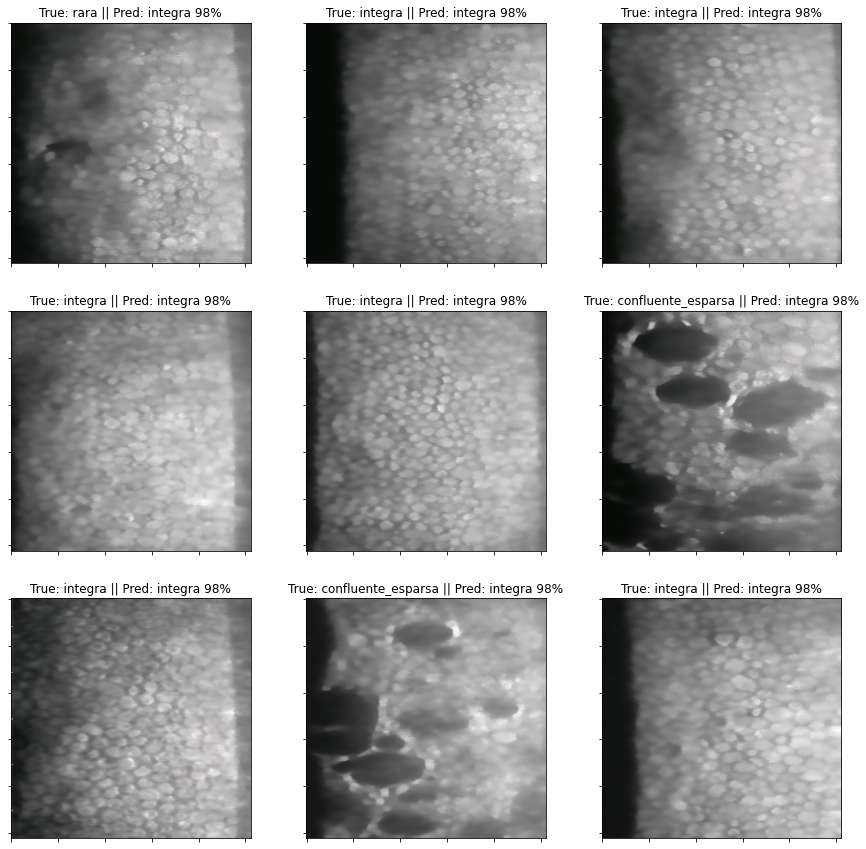

In [ ]:
# Realizando as previsões e exibindo as imagens com os labels verdadeiros e previstos
print("***** Modelo CNN Treinado *****\n")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(131)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(convert_to_RGB(test_data.astype('uint8')[idx]))
  class_idx = desc_label(test_labels[idx])
  
  pred, prob = predict_val(test_data[idx], model_cnn)
  plt.title('True: %s || Pred: %s %d%%' % (CLASS_NAMES[class_idx], CLASS_NAMES[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
predictions_cnn = model_cnn.predict(test_data/255.0)

### VGG19

In [ ]:
avaliacao_vgg19 = model_vgg19.evaluate(test_data, test_labels, verbose=2)

5/5 - 19s - loss: 4.5351 - precision: 0.8143 - recall: 0.8143 - 19s/epoch - 4s/step


***** Modelo VGG19 Treinado *****



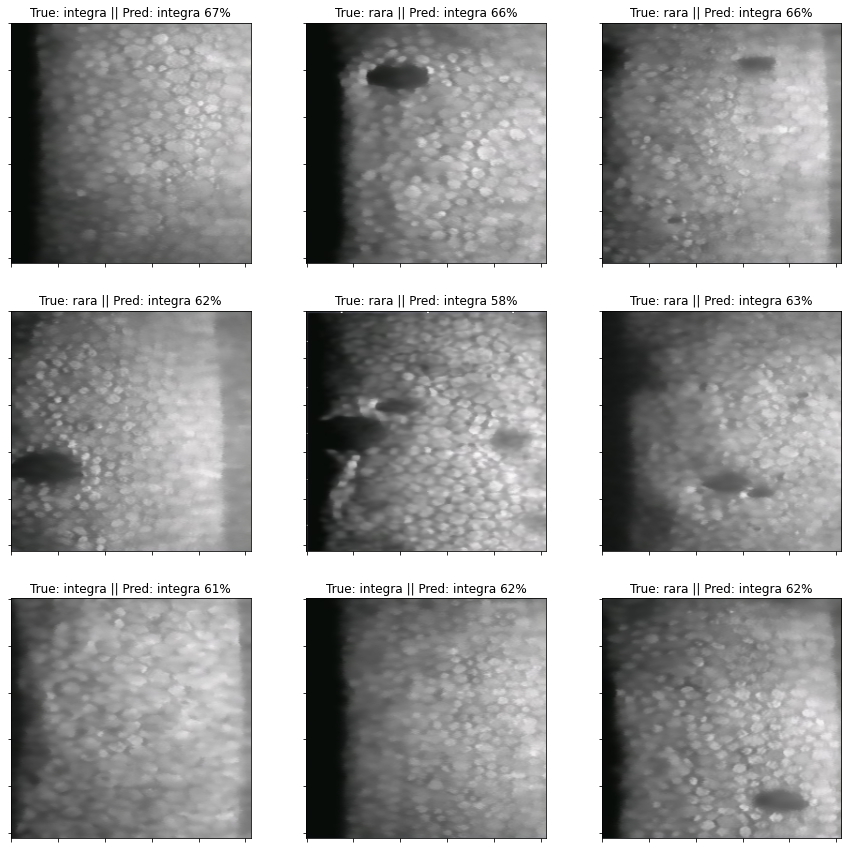

In [ ]:
# Realizando as previsões e exibindo as imagens com os labels verdadeiros e previstos
print("***** Modelo VGG19 Treinado *****\n")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(113)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(convert_to_RGB(test_data.astype('uint8')[idx]))
  class_idx = desc_label(test_labels[idx])
  
  pred, prob = predict_val(test_data[idx], model_vgg19)
  plt.title('True: %s || Pred: %s %d%%' % (CLASS_NAMES[class_idx], CLASS_NAMES[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
predictions_vgg_19 = model_vgg19.predict(test_data/255.0)